# 层次模型——泊松分布

接下来我们对于模型：$$x_{i}\sim P\left(\lambda_{i}\right),\lambda_{i}\sim\Gamma\left(\alpha,\beta\right)$$中的$\alpha,\beta$的后验分布进行画图。

In [1]:
import numpy as np
from scipy import special
np.random.seed(19880505)
x=np.random.poisson(10,50)
x

array([11,  7, 11, 10, 12, 10, 11, 13,  8, 10, 10, 15, 17, 17, 14,  8,  5,
        8,  8,  7, 11,  7,  7, 14, 10,  5,  9, 14,  5,  4, 10,  8,  8,  9,
       19, 11, 11, 13,  7, 14, 12,  4, 10, 12,  9, 14,  8, 17,  8, 14])

## 第一种做法：计算贝叶斯后验分布

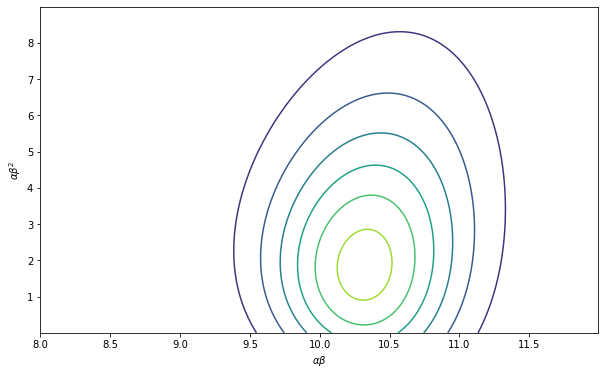

In [2]:
## 计算后验
delta=0.005
## 重新参数化
a=np.arange(8,12,delta)
b=np.arange(0.001,9,delta)
A,B=np.meshgrid(a,b)
Alpha=A**2/B
Beta=B/A
## 计算log(pi)
log_pi=x.sum()*np.log(Beta)
log_pi-=len(x)*special.loggamma(Alpha)
for i in range(len(x)):
    log_pi+=special.loggamma(Alpha+x[i])
log_pi-=(len(x)*Alpha+x.sum())*np.log(1+Beta)
pi=np.exp(log_pi)
## 画图
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 6.0)
fig, ax = plt.subplots()
ax.set_xlabel(r'$\alpha\beta$')
ax.set_ylabel(r'$\alpha\beta^2$')
CS = ax.contour(A, B, pi)
fig.savefig("possion_hier_bayes.eps")

## 第二种方法：经验贝叶斯

In [3]:
from scipy.optimize import minimize

def estimate(x):
    sum_x=x.sum()
    N=len(x)
    ## 目标函数
    def obj(theta):
        alpha=theta[0]
        beta=theta[1]
        return -(sum_x*np.log(beta)+ \
                 special.loggamma(alpha+x).sum() \
                 -N*special.loggamma(alpha) \
                 -(alpha*N+sum_x)*np.log(1+beta))
    ## 求最优化
    res=minimize(obj, np.array([1,1]), \
                 method='nelder-mead', \
                 options={'xtol': 1e-4, 'disp': True})
    return res

theta=estimate(x).x
print("alpha*beta=",theta[0]*theta[1])
print("alpha*beta^2=",theta[0]*theta[1]**2)

Optimization terminated successfully.
         Current function value: -688.734221
         Iterations: 162
         Function evaluations: 306
alpha*beta= 10.3199994976331
alpha*beta^2= 1.82303028330377


In [4]:
lambda_i=(x+theta[0])*(theta[1]/(theta[1]+1))
lambda_i_sd=np.sqrt((x+theta[0])*(theta[1]/(theta[1]+1))**2)
print(np.vstack([x,lambda_i,lambda_i_sd]).T)


[[11.         10.42208782  1.25086596]
 [ 7.          9.82156873  1.21429398]
 [11.         10.42208782  1.25086596]
 [10.         10.27195805  1.24182395]
 [12.         10.57221759  1.25984309]
 [10.         10.27195805  1.24182395]
 [11.         10.42208782  1.25086596]
 [13.         10.72234736  1.2687567 ]
 [ 8.          9.9716985   1.22353946]
 [10.         10.27195805  1.24182395]
 [10.         10.27195805  1.24182395]
 [15.         11.0226069   1.28639864]
 [17.         11.32286645  1.30380188]
 [17.         11.32286645  1.30380188]
 [14.         10.87247713  1.27760812]
 [ 8.          9.9716985   1.22353946]
 [ 5.          9.52130919  1.19558855]
 [ 8.          9.9716985   1.22353946]
 [ 8.          9.9716985   1.22353946]
 [ 7.          9.82156873  1.21429398]
 [11.         10.42208782  1.25086596]
 [ 7.          9.82156873  1.21429398]
 [ 7.          9.82156873  1.21429398]
 [14.         10.87247713  1.27760812]
 [10.         10.27195805  1.24182395]
 [ 5.          9.52130919

## 实际数据应用：OHIE中的急诊次数

In [5]:
import pandas as pd
data=pd.read_csv("../code_in_notes/datasets/OHIE_ED_visit.csv")
data.head(20)

,person_id,sample_ed,ed_visit_09mar2008,ed_visit_30sep2009,num_visit_pre_cens_ed
0,5,1,0,0,0.0
1,8,1,0,1,0.0
2,9,1,1,0,1.0
3,16,1,1,1,1.0
4,18,1,1,0,2.0
5,23,1,0,0,0.0
6,24,1,0,0,0.0
7,29,1,1,1,7.0
8,30,1,0,0,0.0
9,34,1,0,0,0.0


In [6]:
data['num_visit_pre_cens_ed'].describe()

count    24634.000000
mean         0.774133
std          1.863151
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         17.000000
Name: num_visit_pre_cens_ed, dtype: float64

进行估计：

In [7]:
theta=estimate(data['num_visit_pre_cens_ed']).x
print("alpha*beta=",theta[0]*theta[1])
print("alpha*beta^2=",theta[0]*theta[1]**2)

Optimization terminated successfully.
         Current function value: 12866.888199
         Iterations: 45
         Function evaluations: 87
alpha*beta= 0.7737660530364178
alpha*beta^2= 2.159100476763305


预测每一个人的$\lambda_i$

In [8]:
data['pred_lambda']=(data['num_visit_pre_cens_ed']+theta[0])*(theta[1]/(theta[1]+1))
data['pred_lambda_sd']=np.sqrt((data['num_visit_pre_cens_ed']+theta[0])*(theta[1]/(theta[1]+1))**2)
data.head(20)

,person_id,sample_ed,ed_visit_09mar2008,ed_visit_30sep2009,num_visit_pre_cens_ed,pred_lambda,pred_lambda_sd
0,5,1,0,0,0.0,0.204139,0.387663
1,8,1,0,1,0.0,0.204139,0.387663
2,9,1,1,0,1.0,0.940314,0.832006
3,16,1,1,1,1.0,0.940314,0.832006
4,18,1,1,0,2.0,1.676488,1.110940
5,23,1,0,0,0.0,0.204139,0.387663
6,24,1,0,0,0.0,0.204139,0.387663
7,29,1,1,1,7.0,5.357358,1.985938
8,30,1,0,0,0.0,0.204139,0.387663
9,34,1,0,0,0.0,0.204139,0.387663


查看针对每一个visit次数的取值预测出的$\lambda_i$:

In [9]:
data[['num_visit_pre_cens_ed','pred_lambda','pred_lambda_sd']].groupby('num_visit_pre_cens_ed').mean()

,pred_lambda,pred_lambda_sd
num_visit_pre_cens_ed,,
0.0,0.204139,0.387663
1.0,0.940314,0.832006
2.0,1.676488,1.110940
3.0,2.412662,1.332719
4.0,3.148836,1.522528
5.0,3.885010,1.691166
6.0,4.621184,1.844450
7.0,5.357358,1.985938
8.0,6.093533,2.117995


或者，使用Robbins公式：

In [10]:
count=data[['person_id','num_visit_pre_cens_ed']].groupby('num_visit_pre_cens_ed').count()
count['freq']=count['person_id']/count['person_id'].sum()
del count['person_id']
count

,freq
num_visit_pre_cens_ed,
0.0,0.687262
1.0,0.157546
2.0,0.064707
3.0,0.034059
4.0,0.018064
5.0,0.010798
6.0,0.007185
7.0,0.004912
8.0,0.003369


In [11]:
data=pd.merge(data, count, left_on='num_visit_pre_cens_ed', right_index=True )
data['nump1']=data['num_visit_pre_cens_ed']+1
count=count.rename(columns={'freq':'freqp1'})
data=pd.merge(data, count, left_on='nump1', right_index=True )
data['pred_num']=(data['num_visit_pre_cens_ed']+1)*data['freqp1']/data['freq']
data

,person_id,sample_ed,ed_visit_09mar2008,ed_visit_30sep2009,num_visit_pre_cens_ed,pred_lambda,pred_lambda_sd,freq,nump1,freqp1,pred_num
0,5,1,0,0,0.0,0.204139,0.387663,0.687262,1.0,0.157546,0.229238
1,8,1,0,1,0.0,0.204139,0.387663,0.687262,1.0,0.157546,0.229238
5,23,1,0,0,0.0,0.204139,0.387663,0.687262,1.0,0.157546,0.229238
6,24,1,0,0,0.0,0.204139,0.387663,0.687262,1.0,0.157546,0.229238
8,30,1,0,0,0.0,0.204139,0.387663,0.687262,1.0,0.157546,0.229238
...,...,...,...,...,...,...,...,...,...,...,...
15140,45978,1,1,1,14.0,10.510577,2.781657,0.000934,15.0,0.000731,11.739130
19993,60786,1,1,1,14.0,10.510577,2.781657,0.000934,15.0,0.000731,11.739130
22626,68691,1,1,1,14.0,10.510577,2.781657,0.000934,15.0,0.000731,11.739130
22843,69292,1,1,1,14.0,10.510577,2.781657,0.000934,15.0,0.000731,11.739130


In [12]:
data[['num_visit_pre_cens_ed','pred_lambda','pred_num']].groupby('num_visit_pre_cens_ed').mean()

,pred_lambda,pred_num
num_visit_pre_cens_ed,,
0.0,0.204139,0.229238
1.0,0.940314,0.821438
2.0,1.676488,1.579046
3.0,2.412662,2.121573
4.0,3.148836,2.988764
5.0,3.885010,3.992481
6.0,4.621184,4.785311
7.0,5.357358,5.487603
8.0,6.093533,5.421687
